### Preperation

In [1]:
# !pip install gensim --upgrade
# !pip install keras --upgrade
# !pip install pandas --upgrade

Requirement already up-to-date: gensim in /opt/anaconda3/lib/python3.7/site-packages (3.8.3)
Requirement already up-to-date: keras in /opt/anaconda3/lib/python3.7/site-packages (2.3.1)
Requirement already up-to-date: pandas in /opt/anaconda3/lib/python3.7/site-packages (1.0.3)


In [2]:
# !pip install tensorflow

In [3]:
# pip uninstall tensorflow-tensorboard

Note: you may need to restart the kernel to use updated packages.


In [4]:
# pip install --upgrade tensorflow-gpu

  ERROR: Could not find a version that satisfies the requirement tensorflow-gpu (from versions: none)
ERROR: No matching distribution found for tensorflow-gpu
Note: you may need to restart the kernel to use updated packages.


In [5]:
# !pip install tensorflow

In [6]:
# pip install setuptools --upgrade

Requirement already up-to-date: setuptools in /opt/anaconda3/lib/python3.7/site-packages (46.1.3)
Note: you may need to restart the kernel to use updated packages.


In [7]:
# from tensorflow.contrib.keras.preprocessing.text import Tokenizer

ModuleNotFoundError: No module named 'tensorflow.contrib'

In [8]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

Using TensorFlow backend.


In [9]:
#Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [10]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/malachi/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### Settings

In [11]:
# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

### Read Dataset

In [13]:
df = pd.read_csv('./sentiment140.csv', header = None, encoding = "ISO-8859-1")
df.columns = ['target', 'id', 'date', 'flag', 'user', 'text'] #set column names
df.head()

,target,id,date,flag,user,text
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...
4,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...


In [14]:
print("Dataset size:", len(df))

Dataset size: 1600498


In [15]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [16]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: user 647 ms, sys: 8.84 ms, total: 655 ms
Wall time: 655 ms


Text(0.5, 1.0, 'Dataset labels distribuition')

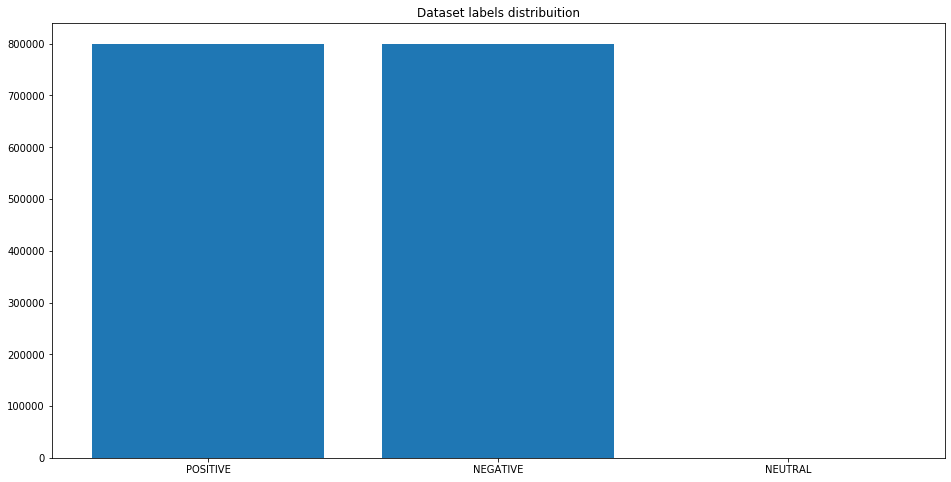

In [17]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

### Pre-Process dataset

In [18]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [19]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [20]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: user 54.5 s, sys: 227 ms, total: 54.7 s
Wall time: 55.2 s


### Split train and test

In [21]:
TRAIN_SIZE = 0.8

df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280398
TEST size: 320100


### Word2Vec

In [22]:
%%time
documents = [_text.split() for _text in df_train.text] 

CPU times: user 3.09 s, sys: 383 ms, total: 3.47 s
Wall time: 3.64 s


In [23]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [24]:
documents = [_text.split() for _text in df_train.text] 
w2v_model.build_vocab(documents)

2020-05-07 13:31:30,657 : INFO : collecting all words and their counts
2020-05-07 13:31:30,658 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-05-07 13:31:30,683 : INFO : PROGRESS: at sentence #10000, processed 72299 words, keeping 13988 word types
2020-05-07 13:31:30,724 : INFO : PROGRESS: at sentence #20000, processed 144356 words, keeping 21673 word types
2020-05-07 13:31:30,769 : INFO : PROGRESS: at sentence #30000, processed 216850 words, keeping 27642 word types
2020-05-07 13:31:30,798 : INFO : PROGRESS: at sentence #40000, processed 288800 words, keeping 33038 word types
2020-05-07 13:31:30,838 : INFO : PROGRESS: at sentence #50000, processed 361113 words, keeping 37809 word types
2020-05-07 13:31:30,869 : INFO : PROGRESS: at sentence #60000, processed 433923 words, keeping 42290 word types
2020-05-07 13:31:30,906 : INFO : PROGRESS: at sentence #70000, processed 505903 words, keeping 46598 word types
2020-05-07 13:31:30,939 : INFO : PROGRESS: at s

2020-05-07 13:31:33,559 : INFO : PROGRESS: at sentence #720000, processed 5189605 words, keeping 201053 word types
2020-05-07 13:31:33,612 : INFO : PROGRESS: at sentence #730000, processed 5261061 words, keeping 202841 word types
2020-05-07 13:31:33,653 : INFO : PROGRESS: at sentence #740000, processed 5333884 words, keeping 204555 word types
2020-05-07 13:31:33,689 : INFO : PROGRESS: at sentence #750000, processed 5406843 words, keeping 206336 word types
2020-05-07 13:31:33,739 : INFO : PROGRESS: at sentence #760000, processed 5478758 words, keeping 208082 word types
2020-05-07 13:31:33,800 : INFO : PROGRESS: at sentence #770000, processed 5550719 words, keeping 209807 word types
2020-05-07 13:31:33,925 : INFO : PROGRESS: at sentence #780000, processed 5623274 words, keeping 211497 word types
2020-05-07 13:31:34,019 : INFO : PROGRESS: at sentence #790000, processed 5695216 words, keeping 213237 word types
2020-05-07 13:31:34,114 : INFO : PROGRESS: at sentence #800000, processed 576724

In [25]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 30385


In [26]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2020-05-07 13:31:46,706 : INFO : training model with 8 workers on 30385 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2020-05-07 13:31:47,772 : INFO : EPOCH 1 - PROGRESS: at 5.61% examples, 441596 words/s, in_qsize 16, out_qsize 0
2020-05-07 13:31:48,811 : INFO : EPOCH 1 - PROGRESS: at 12.77% examples, 503467 words/s, in_qsize 14, out_qsize 1
2020-05-07 13:31:49,850 : INFO : EPOCH 1 - PROGRESS: at 20.24% examples, 532843 words/s, in_qsize 16, out_qsize 1
2020-05-07 13:31:50,920 : INFO : EPOCH 1 - PROGRESS: at 26.49% examples, 520127 words/s, in_qsize 15, out_qsize 0
2020-05-07 13:31:51,953 : INFO : EPOCH 1 - PROGRESS: at 31.93% examples, 502624 words/s, in_qsize 13, out_qsize 2
2020-05-07 13:31:52,976 : INFO : EPOCH 1 - PROGRESS: at 38.67% examples, 508722 words/s, in_qsize 15, out_qsize 0
2020-05-07 13:31:54,044 : INFO : EPOCH 1 - PROGRESS: at 45.71% examples, 513519 words/s, in_qsize 16, out_qsize 1
2020-05-07 13:31:55,047 : INFO : EPOCH 1 - PROGRESS: 

2020-05-07 13:32:39,172 : INFO : EPOCH 4 - PROGRESS: at 6.48% examples, 524733 words/s, in_qsize 12, out_qsize 3
2020-05-07 13:32:40,185 : INFO : EPOCH 4 - PROGRESS: at 13.75% examples, 556735 words/s, in_qsize 16, out_qsize 1
2020-05-07 13:32:41,186 : INFO : EPOCH 4 - PROGRESS: at 20.98% examples, 569890 words/s, in_qsize 15, out_qsize 0
2020-05-07 13:32:42,187 : INFO : EPOCH 4 - PROGRESS: at 27.69% examples, 565506 words/s, in_qsize 16, out_qsize 1
2020-05-07 13:32:43,196 : INFO : EPOCH 4 - PROGRESS: at 34.74% examples, 567086 words/s, in_qsize 14, out_qsize 1
2020-05-07 13:32:44,205 : INFO : EPOCH 4 - PROGRESS: at 41.70% examples, 566709 words/s, in_qsize 14, out_qsize 1
2020-05-07 13:32:45,227 : INFO : EPOCH 4 - PROGRESS: at 46.36% examples, 539011 words/s, in_qsize 16, out_qsize 0
2020-05-07 13:32:46,241 : INFO : EPOCH 4 - PROGRESS: at 50.91% examples, 517789 words/s, in_qsize 14, out_qsize 1
2020-05-07 13:32:47,252 : INFO : EPOCH 4 - PROGRESS: at 56.87% examples, 514057 words/s, 

2020-05-07 13:33:32,112 : INFO : EPOCH 7 - PROGRESS: at 23.68% examples, 385104 words/s, in_qsize 14, out_qsize 1
2020-05-07 13:33:33,163 : INFO : EPOCH 7 - PROGRESS: at 29.31% examples, 394725 words/s, in_qsize 14, out_qsize 1
2020-05-07 13:33:34,171 : INFO : EPOCH 7 - PROGRESS: at 35.28% examples, 407669 words/s, in_qsize 12, out_qsize 3
2020-05-07 13:33:35,183 : INFO : EPOCH 7 - PROGRESS: at 41.37% examples, 418221 words/s, in_qsize 13, out_qsize 2
2020-05-07 13:33:36,253 : INFO : EPOCH 7 - PROGRESS: at 48.41% examples, 432522 words/s, in_qsize 15, out_qsize 0
2020-05-07 13:33:37,333 : INFO : EPOCH 7 - PROGRESS: at 54.27% examples, 433877 words/s, in_qsize 16, out_qsize 0
2020-05-07 13:33:38,350 : INFO : EPOCH 7 - PROGRESS: at 57.62% examples, 419250 words/s, in_qsize 15, out_qsize 0
2020-05-07 13:33:39,448 : INFO : EPOCH 7 - PROGRESS: at 62.05% examples, 411614 words/s, in_qsize 12, out_qsize 3
2020-05-07 13:33:40,640 : INFO : EPOCH 7 - PROGRESS: at 65.63% examples, 397138 words/s,

2020-05-07 13:34:25,937 : INFO : EPOCH - 9 : training on 9232906 raw words (8228852 effective words) took 19.3s, 426678 effective words/s
2020-05-07 13:34:26,971 : INFO : EPOCH 10 - PROGRESS: at 3.67% examples, 297986 words/s, in_qsize 15, out_qsize 0
2020-05-07 13:34:28,051 : INFO : EPOCH 10 - PROGRESS: at 7.99% examples, 314289 words/s, in_qsize 14, out_qsize 1
2020-05-07 13:34:29,078 : INFO : EPOCH 10 - PROGRESS: at 12.56% examples, 330810 words/s, in_qsize 15, out_qsize 0
2020-05-07 13:34:30,161 : INFO : EPOCH 10 - PROGRESS: at 17.00% examples, 332463 words/s, in_qsize 14, out_qsize 2
2020-05-07 13:34:31,167 : INFO : EPOCH 10 - PROGRESS: at 21.64% examples, 341875 words/s, in_qsize 15, out_qsize 0
2020-05-07 13:34:32,181 : INFO : EPOCH 10 - PROGRESS: at 26.50% examples, 350545 words/s, in_qsize 14, out_qsize 1
2020-05-07 13:34:33,199 : INFO : EPOCH 10 - PROGRESS: at 32.90% examples, 373877 words/s, in_qsize 15, out_qsize 0
2020-05-07 13:34:34,199 : INFO : EPOCH 10 - PROGRESS: at 39

2020-05-07 13:35:17,551 : INFO : EPOCH - 12 : training on 9232906 raw words (8228865 effective words) took 17.7s, 465172 effective words/s
2020-05-07 13:35:18,624 : INFO : EPOCH 13 - PROGRESS: at 6.48% examples, 509958 words/s, in_qsize 14, out_qsize 2
2020-05-07 13:35:19,646 : INFO : EPOCH 13 - PROGRESS: at 14.19% examples, 563997 words/s, in_qsize 15, out_qsize 0
2020-05-07 13:35:20,682 : INFO : EPOCH 13 - PROGRESS: at 20.56% examples, 545145 words/s, in_qsize 16, out_qsize 0
2020-05-07 13:35:21,689 : INFO : EPOCH 13 - PROGRESS: at 25.08% examples, 502636 words/s, in_qsize 16, out_qsize 1
2020-05-07 13:35:22,694 : INFO : EPOCH 13 - PROGRESS: at 31.27% examples, 503180 words/s, in_qsize 15, out_qsize 0
2020-05-07 13:35:23,695 : INFO : EPOCH 13 - PROGRESS: at 37.57% examples, 505227 words/s, in_qsize 16, out_qsize 0
2020-05-07 13:35:24,695 : INFO : EPOCH 13 - PROGRESS: at 44.29% examples, 511779 words/s, in_qsize 14, out_qsize 1
2020-05-07 13:35:25,698 : INFO : EPOCH 13 - PROGRESS: at 

2020-05-07 13:36:11,596 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-05-07 13:36:11,613 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-05-07 13:36:11,614 : INFO : EPOCH - 15 : training on 9232906 raw words (8229262 effective words) took 20.0s, 410782 effective words/s
2020-05-07 13:36:12,633 : INFO : EPOCH 16 - PROGRESS: at 6.80% examples, 560249 words/s, in_qsize 15, out_qsize 0
2020-05-07 13:36:13,640 : INFO : EPOCH 16 - PROGRESS: at 14.08% examples, 576692 words/s, in_qsize 16, out_qsize 0
2020-05-07 13:36:14,650 : INFO : EPOCH 16 - PROGRESS: at 21.20% examples, 578578 words/s, in_qsize 16, out_qsize 0
2020-05-07 13:36:15,713 : INFO : EPOCH 16 - PROGRESS: at 25.85% examples, 521830 words/s, in_qsize 15, out_qsize 0
2020-05-07 13:36:16,724 : INFO : EPOCH 16 - PROGRESS: at 31.70% examples, 512686 words/s, in_qsize 16, out_qsize 0
2020-05-07 13:36:17,781 : INFO : EPOCH 16 - PROGRESS: at 36.16% examples, 483935 words/s, in_qsize 14, ou

2020-05-07 13:37:09,557 : INFO : EPOCH 18 - PROGRESS: at 94.96% examples, 381343 words/s, in_qsize 16, out_qsize 2
2020-05-07 13:37:10,248 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-05-07 13:37:10,256 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-05-07 13:37:10,267 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-05-07 13:37:10,313 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-05-07 13:37:10,349 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-05-07 13:37:10,352 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-05-07 13:37:10,371 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-05-07 13:37:10,380 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-05-07 13:37:10,382 : INFO : EPOCH - 18 : training on 9232906 raw words (8229847 effective words) took 21.3s, 386116 effective words/s
2020-05-07 13:37:1

2020-05-07 13:38:01,368 : INFO : EPOCH 21 - PROGRESS: at 63.35% examples, 458789 words/s, in_qsize 12, out_qsize 1
2020-05-07 13:38:02,410 : INFO : EPOCH 21 - PROGRESS: at 68.11% examples, 451830 words/s, in_qsize 15, out_qsize 0
2020-05-07 13:38:03,423 : INFO : EPOCH 21 - PROGRESS: at 71.80% examples, 440297 words/s, in_qsize 13, out_qsize 2
2020-05-07 13:38:04,448 : INFO : EPOCH 21 - PROGRESS: at 76.22% examples, 434371 words/s, in_qsize 14, out_qsize 1
2020-05-07 13:38:05,464 : INFO : EPOCH 21 - PROGRESS: at 80.77% examples, 429981 words/s, in_qsize 15, out_qsize 0
2020-05-07 13:38:06,466 : INFO : EPOCH 21 - PROGRESS: at 85.77% examples, 428702 words/s, in_qsize 16, out_qsize 0
2020-05-07 13:38:07,527 : INFO : EPOCH 21 - PROGRESS: at 90.30% examples, 424107 words/s, in_qsize 15, out_qsize 0
2020-05-07 13:38:08,540 : INFO : EPOCH 21 - PROGRESS: at 96.47% examples, 428338 words/s, in_qsize 15, out_qsize 0
2020-05-07 13:38:09,059 : INFO : worker thread finished; awaiting finish of 7 mo

2020-05-07 13:38:52,692 : INFO : EPOCH 24 - PROGRESS: at 98.20% examples, 567539 words/s, in_qsize 16, out_qsize 0
2020-05-07 13:38:52,852 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-05-07 13:38:52,856 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-05-07 13:38:52,863 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-05-07 13:38:52,919 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-05-07 13:38:52,931 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-05-07 13:38:52,958 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-05-07 13:38:52,959 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-05-07 13:38:52,962 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-05-07 13:38:52,963 : INFO : EPOCH - 24 : training on 9232906 raw words (8229223 effective words) took 14.5s, 567220 effective words/s
2020-05-07 13:38:5

2020-05-07 13:39:39,995 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-05-07 13:39:40,011 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-05-07 13:39:40,024 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-05-07 13:39:40,025 : INFO : EPOCH - 27 : training on 9232906 raw words (8229454 effective words) took 18.2s, 453233 effective words/s
2020-05-07 13:39:41,063 : INFO : EPOCH 28 - PROGRESS: at 6.48% examples, 527359 words/s, in_qsize 15, out_qsize 0
2020-05-07 13:39:42,080 : INFO : EPOCH 28 - PROGRESS: at 13.97% examples, 565977 words/s, in_qsize 16, out_qsize 0
2020-05-07 13:39:43,303 : INFO : EPOCH 28 - PROGRESS: at 20.56% examples, 520238 words/s, in_qsize 11, out_qsize 4
2020-05-07 13:39:44,322 : INFO : EPOCH 28 - PROGRESS: at 24.76% examples, 477614 words/s, in_qsize 15, out_qsize 0
2020-05-07 13:39:45,441 : INFO : EPOCH 28 - PROGRESS: at 29.97% examples, 457825 words/s, in_qsize 15, out_qsize 0
2020-05-07 13:

2020-05-07 13:40:31,261 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-05-07 13:40:31,282 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-05-07 13:40:31,282 : INFO : EPOCH - 30 : training on 9232906 raw words (8228857 effective words) took 14.6s, 564211 effective words/s
2020-05-07 13:40:32,315 : INFO : EPOCH 31 - PROGRESS: at 6.59% examples, 536675 words/s, in_qsize 15, out_qsize 0
2020-05-07 13:40:33,318 : INFO : EPOCH 31 - PROGRESS: at 13.75% examples, 561482 words/s, in_qsize 15, out_qsize 0
2020-05-07 13:40:34,361 : INFO : EPOCH 31 - PROGRESS: at 20.66% examples, 556486 words/s, in_qsize 15, out_qsize 0
2020-05-07 13:40:35,408 : INFO : EPOCH 31 - PROGRESS: at 28.02% examples, 562067 words/s, in_qsize 16, out_qsize 0
2020-05-07 13:40:36,420 : INFO : EPOCH 31 - PROGRESS: at 35.07% examples, 564046 words/s, in_qsize 16, out_qsize 0
2020-05-07 13:40:37,445 : INFO : EPOCH 31 - PROGRESS: at 42.24% examples, 565605 words/s, in_qsize 16, ou

CPU times: user 26min, sys: 15.3 s, total: 26min 16s
Wall time: 9min 16s


(263333193, 295452992)

In [27]:
w2v_model.most_similar("love")

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2020-05-07 13:41:03,653 : INFO : precomputing L2-norms of word weight vectors


[('luv', 0.5740943551063538),
 ('loves', 0.5717892646789551),
 ('adore', 0.5568811893463135),
 ('loved', 0.5138437747955322),
 ('looove', 0.4960799217224121),
 ('amazing', 0.4943632483482361),
 ('lovee', 0.48525866866111755),
 ('looooove', 0.47260385751724243),
 ('awesome', 0.45279037952423096),
 ('loooove', 0.43402644991874695)]

### Tokenize Text

In [28]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 290957
CPU times: user 24.9 s, sys: 213 ms, total: 25.1 s
Wall time: 26 s


In [29]:
%%time
tokenizer = Tokenizer()
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: user 25.3 s, sys: 1.34 s, total: 26.6 s
Wall time: 29.6 s


### Label Encoder

In [30]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['NEGATIVE', 'POSITIVE', 'NEUTRAL', 'NEUTRAL']

In [31]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280398, 1)
y_test (320100, 1)


In [32]:
tokenizer = Tokenizer()
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280398, 300)
y_train (1280398, 1)

x_test (320100, 300)
y_test (320100, 1)


In [33]:
y_train[:10]

array([[0],
       [0],
       [2],
       [0],
       [2],
       [0],
       [0],
       [0],
       [0],
       [2]])

### Embedding Layer (need to fix)

In [34]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))

for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
        
print(embedding_matrix.shape)

(290957, 300)


In [35]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

### Build Model (need to fix)

In [36]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          87287100  
_________________________________________________________________
dropout_1 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 87,447,601
Trainable params: 160,501
Non-trainable params: 87,287,100
_________________________________________________________________


### Compile Model

In [37]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

### Callbacks

In [38]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

### Train 

In [39]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Train on 1152358 samples, validate on 128040 samples
Epoch 1/8
1152358/1152358 [==============================] - 9238s 8ms/step - loss: 0.0203 - accuracy: 5.1373e-04 - val_loss: -0.0024 - val_accuracy: 7.8101e-05


/opt/anaconda3/lib/python3.7/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


Epoch 2/8
1152358/1152358 [==============================] - 11640s 10ms/step - loss: 0.0134 - accuracy: 8.2440e-05 - val_loss: -0.0015 - val_accuracy: 7.8101e-05
Epoch 3/8
1152358/1152358 [==============================] - 10156s 9ms/step - loss: 0.0133 - accuracy: 8.2440e-05 - val_loss: 0.0019 - val_accuracy: 7.8101e-05
Epoch 4/8
1152358/1152358 [==============================] - 8858s 8ms/step - loss: 0.0099 - accuracy: 8.2440e-05 - val_loss: -0.0036 - val_accuracy: 7.8101e-05
Epoch 5/8
1152358/1152358 [==============================] - 8960s 8ms/step - loss: 0.0141 - accuracy: 8.2440e-05 - val_loss: 5.0304e-04 - val_accuracy: 7.8101e-05
Epoch 6/8
1152358/1152358 [==============================] - 8788s 8ms/step - loss: 0.0126 - accuracy: 8.2440e-05 - val_loss: -1.6241e-04 - val_accuracy: 7.8101e-05
Epoch 7/8
1152358/1152358 [==============================] - 8946s 8ms/step - loss: 0.0125 - accuracy: 8.2440e-05 - val_loss: 5.9953e-05 - val_accuracy: 7.8101e-05
Epoch 8/8
1152358/1152

### Evaluate

In [40]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

320100/320100 [==============================] - 812s 3ms/step

ACCURACY: 0.00010621680848998949
LOSS: -0.02723734414957345
CPU times: user 26min 55s, sys: 8min 59s, total: 35min 55s
Wall time: 13min 32s


### Plot 

In [46]:
history.history

{'val_loss': [-0.0023882761332271163,
  -0.0015267150322372785,
  0.0018763560051245686,
  -0.0036038411106778063,
  0.0005030375650319568,
  -0.0001624067438203668,
  5.99526346337326e-05,
  0.0015820192344782316],
 'val_accuracy': [7.81005946919322e-05,
  7.81005946919322e-05,
  7.81005946919322e-05,
  7.81005946919322e-05,
  7.81005946919322e-05,
  7.81005946919322e-05,
  7.81005946919322e-05,
  7.81005946919322e-05],
 'loss': [0.02031959138770794,
  0.013354436841939208,
  0.013346589464620614,
  0.0099375405625802,
  0.014083638338589156,
  0.012554307373633786,
  0.012486721776349118,
  0.012430219740612918],
 'accuracy': [0.00051372923,
  8.2439656e-05,
  8.2439656e-05,
  8.2439656e-05,
  8.2439656e-05,
  8.2439656e-05,
  8.2439656e-05,
  8.2439656e-05],
 'lr': [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001]}

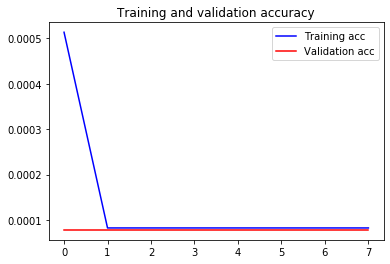

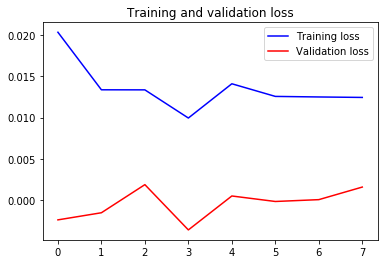

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

### Predict

In [48]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [49]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at} 

In [50]:
predict("I love the music")

{'label': 'POSITIVE',
 'score': 0.9965639710426331,
 'elapsed_time': 0.6580479145050049}

In [51]:
predict("I hate the rain")

{'label': 'POSITIVE',
 'score': 0.9965639710426331,
 'elapsed_time': 0.04838991165161133}

In [52]:
predict("i don't know what i'm doing")

{'label': 'POSITIVE',
 'score': 0.9965639710426331,
 'elapsed_time': 0.050244808197021484}

### Confusion Matrix 

In [53]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

320100/320100 [==============================] - 1418s 4ms/step


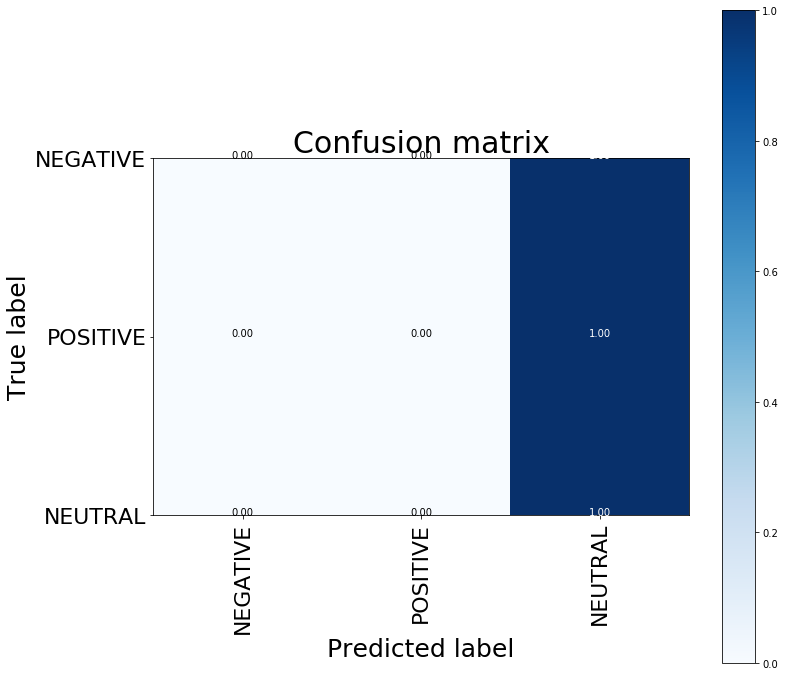

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

    NEGATIVE       0.00      0.00      0.00    159167
     NEUTRAL       0.00      0.00      0.00        34
    POSITIVE       0.50      1.00      0.67    160899

    accuracy                           0.50    320100
   macro avg       0.17      0.33      0.22    320100
weighted avg       0.25      0.50      0.34    320100

CPU times: user 28min 28s, sys: 14min 20s, total: 42min 48s
Wall time: 23min 47s


0.5026522961574508

In [54]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

print(classification_report(y_test_1d, y_pred_1d))


accuracy_score(y_test_1d, y_pred_1d)

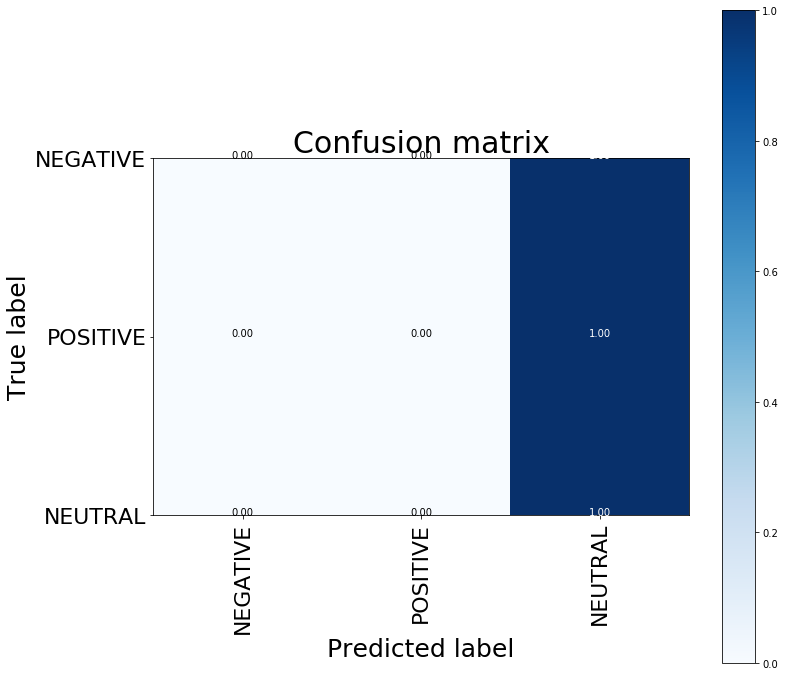

CPU times: user 2.34 s, sys: 129 ms, total: 2.47 s
Wall time: 2.05 s


In [55]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

### Classification report

In [56]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.00      0.00      0.00    159167
     NEUTRAL       0.00      0.00      0.00        34
    POSITIVE       0.50      1.00      0.67    160899

    accuracy                           0.50    320100
   macro avg       0.17      0.33      0.22    320100
weighted avg       0.25      0.50      0.34    320100



### Accuracy Score

In [57]:
accuracy_score(y_test_1d, y_pred_1d)

0.5026522961574508

### Save Model

In [58]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

2020-05-08 11:16:52,563 : INFO : saving Word2Vec object under model.w2v, separately None
2020-05-08 11:16:52,600 : INFO : not storing attribute vectors_norm
2020-05-08 11:16:52,606 : INFO : not storing attribute cum_table
2020-05-08 11:16:56,878 : INFO : saved model.w2v
